In [1]:
import torch
import os 

from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchmetrics import functional as FM

import pytorch_lightning as pl

import matplotlib.pyplot as plt
import numpy as np

d:\conda\envs\torch-light\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Lightning FashionMNIST CNN 학습

In [2]:
dataset = FashionMNIST(os.getcwd(), train=True, download=True, transform=transforms.ToTensor())
train, val = random_split(dataset, [55000, 5000])
test = FashionMNIST(os.getcwd(), train=False, download=True, transform=transforms.ToTensor())

In [3]:
batch_size = 256

train_dataloader = DataLoader(train, batch_size=batch_size, num_workers=2)
val_dataloader = DataLoader(val, batch_size=batch_size, num_workers=2)
test_dataloader = DataLoader(test, batch_size=batch_size, num_workers=2)

In [24]:
train.dataset.data.shape

torch.Size([60000, 28, 28])

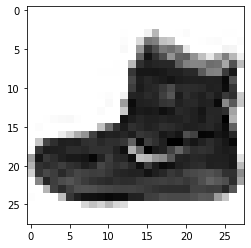

In [25]:
plt.imshow(dataset.data[0], cmap="binary")

In [26]:
dataset.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [27]:

class Classifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*3*3, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64,10),
        )
    
    def forward(self, batch):
        return self.fc(self.conv(batch))
    
    def training_step(self, batch, batch_idx):
        X,y = batch
        logits = self(X)
        loss = F.cross_entropy(logits, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        pred = self(X)
        val_loss = F.cross_entropy(pred, y)
        val_acc = FM.accuracy(pred, y)
        self.log("val_loss", val_loss)
        self.log("val_acc", val_acc)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        X, y = batch
        pred = self(X)
        acc = FM.accuracy(pred, y)
        loss = F.cross_entropy(pred, y)
        self.log("test_loss", loss)
        self.log("test_acc", acc)
    
    def configure_optimizers(self):
        optimizer = torch.optim.NAdam(self.parameters())
        return optimizer

In [28]:
model = Classifier()

In [29]:
trainer = pl.Trainer(max_epochs=10, accelerator='gpu', devices=1, default_root_dir="./checkpoint")
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | conv | Sequential | 1.1 M 
1 | fc   | Sequential | 303 K 
------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.655     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

d:\conda\envs\torch-light\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


d:\conda\envs\torch-light\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 9: 100%|██████████| 235/235 [00:15<00:00, 15.20it/s, loss=0.236, v_num=8]


In [30]:
trainer.test(model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
d:\conda\envs\torch-light\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 35.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.890500009059906
        test_loss           0.3365372121334076
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3365372121334076, 'test_acc': 0.890500009059906}]

### Load from checkpoint

In [31]:
model_from_checkpoint = Classifier.load_from_checkpoint("./checkpoint/lightning_logs/version_2/checkpoints/epoch=9-step=4300.ckpt")

In [32]:
model_from_checkpoint.eval()

Classifier(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2304, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (

In [33]:
pred = model_from_checkpoint(test[0][0][None, :])
dataset.classes[pred.argmax().item()]

'Ankle boot'

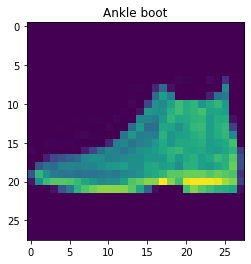

In [34]:
plt.title(dataset.classes[test[0][1]])
plt.imshow(test[0][0][0])

### EarlyStopping

In [35]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [36]:
model = Classifier()
earlystop_callback = EarlyStopping(monitor="val_loss", min_delta=0.00, patience=3, verbose=True, mode="min")
trainer = pl.Trainer(max_epochs=50, accelerator='gpu', devices=1, enable_checkpointing=False, callbacks=[earlystop_callback])
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | conv | Sequential | 1.1 M 
1 | fc   | Sequential | 303 K 
------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.655     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 235/235 [00:14<00:00, 15.92it/s, loss=0.656, v_num=27]

Metric val_loss improved. New best score: 0.510


Epoch 1: 100%|██████████| 235/235 [00:15<00:00, 15.66it/s, loss=0.468, v_num=27]

Metric val_loss improved by 0.115 >= min_delta = 0.0. New best score: 0.395


Epoch 2: 100%|██████████| 235/235 [00:14<00:00, 15.75it/s, loss=0.412, v_num=27]

Metric val_loss improved by 0.061 >= min_delta = 0.0. New best score: 0.334


Epoch 3: 100%|██████████| 235/235 [00:14<00:00, 16.03it/s, loss=0.366, v_num=27]

Metric val_loss improved by 0.026 >= min_delta = 0.0. New best score: 0.308


Epoch 4: 100%|██████████| 235/235 [00:14<00:00, 15.97it/s, loss=0.346, v_num=27]

Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.295


Epoch 5: 100%|██████████| 235/235 [00:14<00:00, 15.71it/s, loss=0.311, v_num=27]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.291


Epoch 6: 100%|██████████| 235/235 [00:17<00:00, 13.81it/s, loss=0.289, v_num=27]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.288


Epoch 7: 100%|██████████| 235/235 [00:15<00:00, 15.02it/s, loss=0.278, v_num=27]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.284


Epoch 9: 100%|██████████| 235/235 [00:16<00:00, 14.66it/s, loss=0.254, v_num=27]

Metric val_loss improved by 0.020 >= min_delta = 0.0. New best score: 0.264


Epoch 10: 100%|██████████| 235/235 [00:15<00:00, 15.32it/s, loss=0.232, v_num=27]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.255


Epoch 13: 100%|██████████| 235/235 [00:14<00:00, 15.78it/s, loss=0.199, v_num=27]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.255. Signaling Trainer to stop.


Epoch 13: 100%|██████████| 235/235 [00:14<00:00, 15.77it/s, loss=0.199, v_num=27]


In [37]:
model.eval()

Classifier(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2304, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (

In [38]:
trainer.validate(model, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 20/20 [00:00<00:00, 35.59it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.9129999876022339
        val_loss            0.28538748621940613
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.28538748621940613, 'val_acc': 0.9129999876022339}]

### 짧은 모델 실행

* train, validation, test에 5개의 batch만 사용

In [40]:
model = Classifier()
trainer = pl.Trainer(max_epochs=10, accelerator="gpu", devices=1, fast_dev_run=True)
trainer.fit(model, train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
d:\conda\envs\torch-light\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | N

Epoch 0: 100%|██████████| 1/1 [00:03<00:00,  3.45s/it, loss=2.3, v_num=]


### Weight Summary

In [45]:
from pytorch_lightning.callbacks import ModelSummary

model = Classifier()
trainer = pl.Trainer(max_epochs=10, accelerator="gpu", devices=1, callbacks=[ModelSummary(max_depth=-1)])

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [46]:
trainer.fit(model, train_dataloader)

d:\conda\envs\torch-light\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name    | Type       | Params
----------------------------------------
0  | conv    | Sequential | 1.1 M 
1  | conv.0  | Conv2d     | 3.2 K 
2  | conv.1  | ReLU       | 0     
3  | conv.2  | MaxPool2d  | 0     
4  | conv.3  | Conv2d     | 73.9 K
5  | conv.4  | ReLU       | 0     
6  | conv.5  | Conv2d     | 147 K 
7  | conv.6  | ReLU       | 0     
8  | conv.7  | MaxPool2d  | 0     
9  | conv.8  | Conv2d     | 295 K 
10 | conv.9  | ReLU       | 0     
11 | conv.10 | Conv2d     | 590 K 
12 | conv.11 | ReLU       | 0     
13 | conv.12 | MaxPool2d  | 0     
14 | fc      | Sequential | 303 K 
15 | fc.0    | Flatten    | 0     
16 | fc.1    | Linear   

Epoch 9: 100%|██████████| 215/215 [00:12<00:00, 16.56it/s, loss=0.244, v_num=28]


### input, output layer dimension

In [49]:
class Classifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.example_input_array = torch.Tensor(32, 1, 28, 28)
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*3*3, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64,10),
        )
    
    def forward(self, batch):
        return self.fc(self.conv(batch))
    
    def training_step(self, batch, batch_idx):
        X,y = batch
        logits = self(X)
        loss = F.cross_entropy(logits, y)
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        pred = self(X)
        val_loss = F.cross_entropy(pred, y)
        val_acc = FM.accuracy(pred, y)
        self.log("val_loss", val_loss)
        self.log("val_acc", val_acc)
        return val_loss
    
    def test_step(self, batch, batch_idx):
        X, y = batch
        pred = self(X)
        acc = FM.accuracy(pred, y)
        loss = F.cross_entropy(pred, y)
        self.log("test_loss", loss)
        self.log("test_acc", acc)
    
    def configure_optimizers(self):
        optimizer = torch.optim.NAdam(self.parameters())
        return optimizer

In [51]:
model = Classifier()
trainer = pl.Trainer(max_epochs=10, accelerator="gpu", devices=1, fast_dev_run=True, callbacks=[ModelSummary(max_depth=-1)])
trainer.fit(model, train_dataloader)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name    | Type       | Params | In sizes          | Out sizes        
--------------------------------------------------

Epoch 0: 100%|██████████| 1/1 [00:03<00:00,  3.30s/it, loss=2.31, v_num=]


### Profiling

In [55]:
model = Classifier()
trainer = pl.Trainer(max_epochs=3, accelerator="gpu", devices=1, profiler="simple")
trainer.fit(model, train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | In sizes        | Out sizes      
------------------------------------------------------------------------
0 | conv | Sequential | 1.1 M  | [32, 1, 28, 28] | [32, 256, 3, 3]
1 | fc   | Sequential | 303 K  | [32, 256, 3, 3] | [32, 10]       
------------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.655     Total estimated model params size (MB)


Epoch 2: 100%|██████████| 215/215 [00:13<00:00, 16.08it/s, loss=0.388, v_num=30]


FIT Profiler Report

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Action                                                                                                                                                                                                    	|  Mean duration (s)	|  Num calls      	|  Total time (s) 	|  Percentage %   	|
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  Total                                                                     

In [57]:
from pytorch_lightning.profiler import AdvancedProfiler

In [58]:
model = Classifier()
# trainer = pl.Trainer(max_epochs=3, accelerator="gpu", devices=1, profiler="advanced")
profiler = AdvancedProfiler(dirpath=".", filename="perf_logs")
trainer = pl.Trainer(max_epochs=3, accelerator="gpu", devices=1, profiler=profiler)
trainer.fit(model, train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\conda\envs\torch-light\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | In sizes        | Out sizes      
------------------------------------------------------------------------
0 | conv | Sequential | 1.1 M  | [32, 1, 28, 28] | [32, 256, 3, 3]
1 | fc   | Sequential | 303 K  | [32, 256, 3, 3] | [32, 10]       
------------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.655     Total estimated model params size (MB)
d:\conda\envs\torch-light\lib\site-pac

Epoch 2: 100%|██████████| 215/215 [00:12<00:00, 16.80it/s, loss=0.402, v_num=31]


### Accelerator usage

In [63]:
from pytorch_lightning.callbacks import DeviceStatsMonitor

model = Classifier()
trainer  = pl.Trainer(max_epochs=3, accelerator="gpu", callbacks=[DeviceStatsMonitor()])
trainer.fit(model, train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
d:\conda\envs\torch-light\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params | In sizes        | Out sizes      
------------------------------------------------------------------------
0 | conv | Sequential | 1.1 M  | [32, 1, 28, 28] | [32, 256, 3, 3]
1 | fc   | Sequential | 303 K  | [32, 256, 3, 3] | [32, 10]       
------------------------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.655     Total estimated model params size (MB)
d:\conda\envs\torch-light\lib\site-pac

Epoch 2: 100%|██████████| 215/215 [00:14<00:00, 14.66it/s, loss=0.43, v_num=34] 
